In [1]:
import torch
import torch.nn as nn
import numpy as np


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\Админ\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\ipykernel_l

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):
        """Регистрация блоков"""
        super().__init__()
        self.lin1 = nn.Linear(256, 64)  # Полносвязный слой 1
        self.lin2 = nn.Linear(64, 16)   # Полносвязный слой 2
        self.lin3 = nn.Linear(16, 4)    # Полносвязный слой 3
        self.relu = nn.ReLU()           # Функция активации 1
        self.tanh = nn.Tanh()           # Функция активации 2
        self.soft = nn.Softmax(dim=1)   # Функция активации 3
        
    def forward(self, x):
        """Прямой проход"""
        h = self.lin1(x)
        h = self.relu(h)
        h = self.lin2(h)
        h = self.tanh(h)
        h = self.lin3(h)
        y = self.soft(h)
        return y

x = torch.randn(9, 256)
model = SimpleModel()

Epoch [5/100], Loss: 0.6794
Epoch [10/100], Loss: 0.6912
Epoch [15/100], Loss: 0.6802
Epoch [20/100], Loss: 0.6697
Epoch [25/100], Loss: 0.7004
Epoch [30/100], Loss: 0.6820
Epoch [35/100], Loss: 0.6805
Epoch [40/100], Loss: 0.6958
Epoch [45/100], Loss: 0.6995
Epoch [50/100], Loss: 0.7001
Epoch [55/100], Loss: 0.6970
Epoch [60/100], Loss: 0.7039
Epoch [65/100], Loss: 0.6869
Epoch [70/100], Loss: 0.6960
Epoch [75/100], Loss: 0.6912
Epoch [80/100], Loss: 0.6831
Epoch [85/100], Loss: 0.6844
Epoch [90/100], Loss: 0.6912
Epoch [95/100], Loss: 0.6913
Epoch [100/100], Loss: 0.7054
Test Accuracy: 0.4700


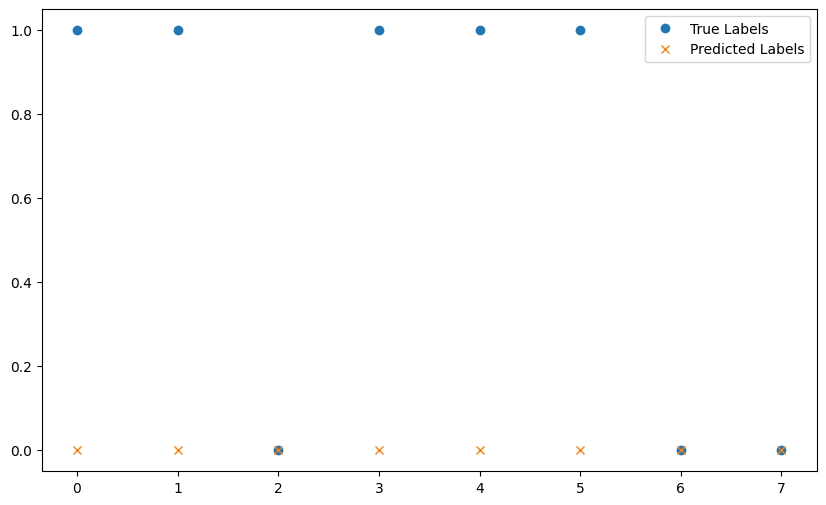

In [21]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# 1. Подготовка данных
# Генерация синтетических временных данных
def generate_time_series(data_size, n_steps):
    time = torch.arange(data_size * n_steps, dtype=torch.float32)
    data = torch.sin(time * 0.01) + torch.randn(len(time)) * 0.1
    data = data.reshape((data_size, n_steps))
    return data

# Генерация меток (0 или 1)
def generate_labels(data_size):
    return torch.randint(0, 2, size=(data_size, 1), dtype=torch.float32)

data_size = 1000
n_steps = 50
data = generate_time_series(data_size, n_steps)
labels = generate_labels(data_size)

# Разделение данных на вход (X) и метки (y)
X = data.unsqueeze(-1)  # (batch_size, seq_len, input_size)
y = labels

# Создание TensorDataset
dataset = TensorDataset(X, y)

# Разделение на обучающую и тестовую выборки
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Создание DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 2. Создание модели LSTM для бинарной классификации
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Берем только последний выход LSTM
        out = self.sigmoid(out)  # Применяем сигмоиду для получения вероятности
        return out

# Параметры модели
input_size = 1  # Один признак на каждый временной шаг
hidden_size = 50
output_size = 1  # Один выход для бинарной классификации
num_layers = 1

model = LSTMBinaryClassifier(input_size, hidden_size, output_size, num_layers)

# 3. Определение функции потерь и оптимизатора
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass и оптимизация
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Оценка модели
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(batch_y.tolist(), label='True Labels', marker='o', linestyle='None')
plt.plot(predicted.tolist(), label='Predicted Labels', marker='x', linestyle='None')
plt.legend()
plt.show()

Epoch [5/100], Loss: 0.6975
Epoch [10/100], Loss: 0.6923
Epoch [15/100], Loss: 0.7004
Epoch [20/100], Loss: 0.6938
Epoch [25/100], Loss: 0.6925
Epoch [30/100], Loss: 0.6911
Epoch [35/100], Loss: 0.6932
Epoch [40/100], Loss: 0.6901
Epoch [45/100], Loss: 0.6855
Epoch [50/100], Loss: 0.6872
Epoch [55/100], Loss: 0.6878
Epoch [60/100], Loss: 0.6543
Epoch [65/100], Loss: 0.6797
Epoch [70/100], Loss: 0.6755
Epoch [75/100], Loss: 0.6769
Epoch [80/100], Loss: 0.6776
Epoch [85/100], Loss: 0.7040
Epoch [90/100], Loss: 0.6983
Epoch [95/100], Loss: 0.6592
Epoch [100/100], Loss: 0.6740
Test Accuracy: 0.5100


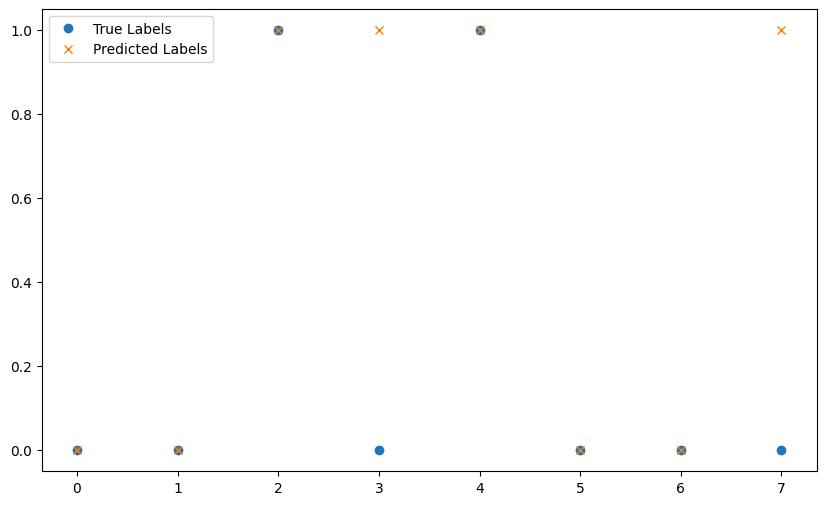

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split

# 1. Подготовка данных

def generate_time_series(data_size, n_steps):
    time = torch.arange(data_size * n_steps, dtype=torch.float32)
    data = torch.sin(time * 0.01) + torch.randn(len(time)) * 0.1
    data = data.reshape((data_size, n_steps))
    return data

# Генерация меток (0 или 1)
def generate_labels(data_size):
    return torch.randint(0, 2, size=(data_size, 1), dtype=torch.float32)

data_size = 1000
n_steps = 50
data = generate_time_series(data_size, n_steps)
labels = generate_labels(data_size)

# Разделение данных на вход (X) и метки (y)
X = data.unsqueeze(-1)  # (batch_size, seq_len, input_size)
y = labels

# Создание TensorDataset
dataset = TensorDataset(X, y)

# Разделение на обучающую и тестовую выборки
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Создание DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 2. Создание модели LSTM для бинарной классификации
class LSTMBinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMBinaryClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Берем только последний выход LSTM
        out = self.sigmoid(out)  # Применяем сигмоиду для получения вероятности
        return out

# Параметры модели
input_size = 1  # Один признак на каждый временной шаг
hidden_size = 50
output_size = 1  # Один выход для бинарной классификации
num_layers = 1

model = LSTMBinaryClassifier(input_size, hidden_size, output_size, num_layers)

# 3. Определение функции потерь и оптимизатора
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 4. Обучение модели
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass и оптимизация
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 5. Оценка модели
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy:.4f}')

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(batch_y.tolist(), label='True Labels', marker='o', linestyle='None')
plt.plot(predicted.tolist(), label='Predicted Labels', marker='x', linestyle='None')
plt.legend()
plt.show()